In [1]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [2]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize
from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Divide Dataset into train and test

In [3]:
train_batch_size = 1
test_batch_size = 1
split_percent = 0.8

origami_dataset_dir = "small_data/s_test"
inp='in'
out='out'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor()])
origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

# Check your Dataset 
## Remeber the below cell consumes precious GPU if used in notebook. 
Its better not run this part when u r planning to train

Input to network


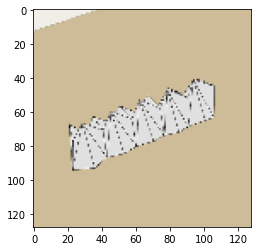

Output of network (To be verified with)


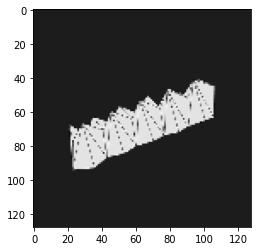

In [4]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

# Functions of training and testing of model

In [5]:
def train(model, device, train_loader, optimizer, epoch,log_interval=12):
    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l2(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    scheduler.step()

def test(model, device, test_loader,save_img=False,ep=None,save_folder=None):
    model.eval()
    l2 = nn.MSELoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l2(output,target) # sum up batch loss
    test_loss /= max(1,c)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

    if save_img:
        kwargs =  {'nrow':4, "padding":2, "pad_value":1}
        images_show = 8
        op = output[:images_show,:].cpu()
        # torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
        tar = data[:images_show,:].cpu()
        # torchvision.utils.save_image(tar, f'{ep}_in.png',**kwargs)
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder, f'{ep}_in.png'),**kwargs)
        print('image saved')

# Start Training Here

In [6]:
epochs = 1000
save_model = True
load_model = False
saved_pth = 'AE.pt'

model = AugmentedAutoencoder().to(device)

if os.path.exists(saved_pth) and load_model:
    model.load_state_dict(torch.load(saved_pth))

optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

if not os.path.exists('trained_results'):
    os.mkdir('trained_results')

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    
    if save_model and epoch%20 ==0:
        test(model, device, test_loader,save_img=True, ep = epoch, save_folder='trained_results')
        torch.save(model.state_dict(), saved_pth)

/home/rohit/projects/3D_reconstruction/cv/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Train Epoch: 1 	Loss: 0.072573
Train Epoch: 2 	Loss: 0.072063
Train Epoch: 3 	Loss: 0.070277
Train Epoch: 4 	Loss: 0.059943
Train Epoch: 5 	Loss: 0.036717
Train Epoch: 6 	Loss: 0.041194
Train Epoch: 7 	Loss: 0.028820
Train Epoch: 8 	Loss: 0.027899
Train Epoch: 9 	Loss: 0.039444
Train Epoch: 10 	Loss: 0.036924

Test set: Average loss: 0.0674

image saved
Train Epoch: 11 	Loss: 0.041353
Train Epoch: 12 	Loss: 0.041780
Train Epoch: 13 	Loss: 0.041465
Train Epoch: 14 	Loss: 0.027067
Train Epoch: 15 	Loss: 0.024956
Train Epoch: 16 	Loss: 0.039402
Train Epoch: 17 	Loss: 0.026760
Train Epoch: 18 	Loss: 0.041311
Train Epoch: 19 	Loss: 0.037803
Train Epoch: 20 	Loss: 0.025217

Test set: Average loss: 0.0676

image saved
Train Epoch: 21 	Loss: 0.036136


KeyboardInterrupt: 

# Validate with your own Image
Just change the folder in variable `origami_test_dir`

In [13]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save =False):
    model.eval()
    test_loss = 0
    correct = 0
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        sample = sample.to(device)
        output = model(sample)
        encodings = model.encoder_op(sample)
        
    if viewer:
        images_show = 8
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op,**kwargs))
            
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save:
        op = output[:images_show,:].cpu()
        torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
        torchvision.utils.save_image(sample[:images_show,:].cpu(), f'{ep}_in.png',**kwargs)
        
    return sample, output, encodings

In [14]:
origami_test_dir = "MarowDataset/Test"
val_batch_size = 12

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_test_dir, transform=trns)
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=True,**kwargs)

/home/rohit/projects/3D_reconstruction/cv/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Reconstructed


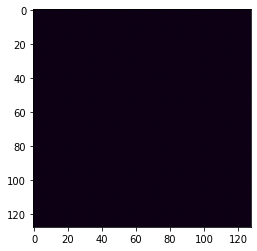

Input to Netowrk


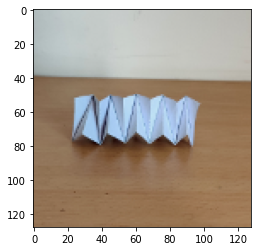

In [15]:
model = AugmentedAutoencoder().to(device)

sample, output, encodings = cross_validation(model, device, val_loader,viewer=True)